# Traffic Simulation Position Errors
(I'm partially writing this as an exercise in writing Jupyter notebooks as suggested.)

There are lots of apparent errors in our traffic simulation dataset.
I'm not sure if that's because we're misunderstanding the specifics of the dataset, or if the dataset itself has errors.

## Calculated vs. Listed Positions

Within the traffic simulation dataset, vehicle positions are listed in two ways:
 - As a pair of (X, Y) UTM coordinates (specifically using projection EPSG:26916), and
 - As a road link coupled with an offset and direction on that link.

As mentioned in the `Readme.txt` for the traffic simulation dataset, these representations should be equivalent for each vehicle record.
For example, we should be able to compute the (X, Y) position for a vehicle by interpolating along the link it's travelling on, given the vehicle's offset, direction, and the road network data.

However, if you actually try to do this with the datasets provided, two problems come up:
 - For some records, the given offsets are larger than the lengths of the corresponding links (e.g. a vehicle is listed as having driven 120 meters down a link that is only 15 meters long)
 - Even when the listed offset for a vehicle is valid, the interpolated UTM position of the vehicle does not match the listed UTM position, for the vast majority of records.

To investigate this, I randomly sampled 1,242,228 (about 5%) records from the entire traffic simulation dataset,
calculated a UTM position for each record by interpolating using the listed link offset/distance (as described above), and measured the distance between the calculated position and the listed UTM position in each record.

## Scripts

The Python scripts used to perform the above sampling and calculations can be found in this repository:
 - `sample_traffic_data.py` pulls samples from the (entire) traffic simulation dataset,
 - `vehicle_pos_error.py` calculates distances between interpolated and listed positions for sampled data from the previous script.

These scripts should be run from the repository root, and require specifying the base directory for all of the Challenge 4 datasets
(i.e. the folder containing the `Road Network/`, `Vehicle Data/`, etc. subfolders).

## Computed Data

The computed data of interest here is found in `data/simulation_position_errors.csv` (which can be generated with the above scripts).

Only samples that have valid link offsets are included in this data, which by itself halves our sample size to about 558 thousand samples:


In [39]:
import csv
import numpy as np

# Load the simulation position error data file
with open("data/simulation_position_errors.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)
    data = np.fromiter((float(row[2]) for row in reader), float)

print(data.shape)

(557682,)


The distances between the listed and computed positions are given in meters.

## Analysis

The distribution of this discrepancy is highly skewed:

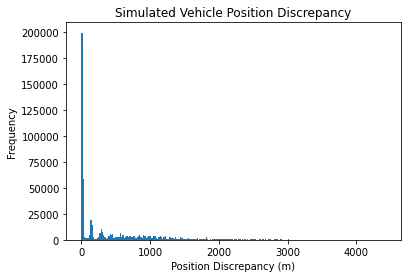

In [40]:
import matplotlib.pyplot as plt

plt.hist(data, bins='auto')
plt.xlabel("Position Discrepancy (m)")
plt.ylabel("Frequency")
plt.title("Simulated Vehicle Position Discrepancy")
plt.show()

Looking more closely at the lowest values reveals many discrete peaks:

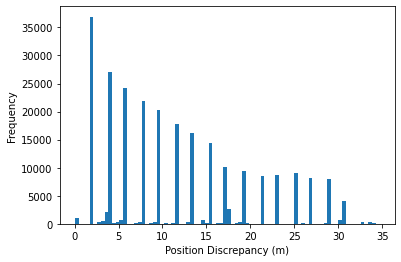

In [41]:
plt.hist(data[data < 35], bins='auto')
plt.xlabel("Position Discrepancy (m)")
plt.ylabel("Frequency")
plt.show()

This may occur because the code for interpolating vehicle positions doesn't take vehicle lanes into account (yet): interpolated positions always lie along the center of the road.

However, this explanation makes less sense for larger discrepancies; for example, a vehicle with an apparent discrepancy of 20 meters would already be seven to eight lane-widths away from the center of the road, assuming that a lane is about 2.5 to 3 meters wide.

To make things worse, the vast majority of our samples have an even larger position discrepancy:

In [42]:
print(np.count_nonzero(data > 20))

348424


And of course, this doesn't account for the samples that don't have valid link offsets to begin with, which form over half of our overall sample.

## Other Notes

Documentation I've found online (by searching for "transims cell size" on Google) suggests that TRANSIMS uses a default grid cell size of 7.5 meters.
Based on that, I checked the listed link offsets for some of the sampled records, and all of the offsets I checked were in fact multiples of 7.5.

Granted, this isn't rigorous proof, but it gives me at least some reason to believe that I'm not just interpreting the sampled link offsets with the wrong units of measurement.

UTM coordinates, however, always use meters by convention. (I think this might be part of the definition of the projection itself?)

Finally, this document doesn't mention the _other_ problems I found with the vehicle positions in this dataset:
 - Many listed vehicle positions lie completely outside of the boundaries of the road network.
 - Many vehicle positions (both inside and outside of the network) put vehicles inside buildings, within rivers, on train tracks, or (in a few notable cases) within Lake Michigan.